# Librerie

In [1]:
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

In [2]:
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races.csv")

## Script schema plots

In [3]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [4]:
def PlotDistributionFeatures(Dataset, Features):
    
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins = 10, alpha = 0.7, color = "blue")
                   ]

    fig = plt.figure(figsize = (3*len(PlotsLambda), 2*len(Features)))   #Altezza, larghezza
    gs = gridspec.GridSpec(len(Features), len(PlotsLambda), figure=fig)
      
    i = 0

    for feature in Features:
        
        
        ax = fig.add_subplot(gs[i//len(PlotsLambda), i%len(PlotsLambda)])
        ax.set_title(feature) 
        
        for plot in PlotsLambda:    
            plot(feature, ax)
            
            i += 1

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()
    
    Fs = []
    i = 0
    r = 4
    

    while(i+r < len(Features)):
        Fs.append(Features[i: i+r])
        i += r
        
    if(i < len(Features)-1): Fs.append(Features[i:])
    
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
    
        seaborn.boxenplot(Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(Dataset[fs], kind="box") 
        plt.show()
    

# **Cleaning cyclists dataset**

## Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [5]:
#Scott Davies, nazionalità: Regno Unito
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

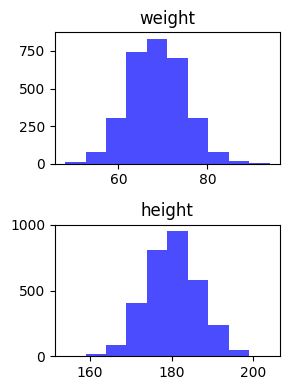

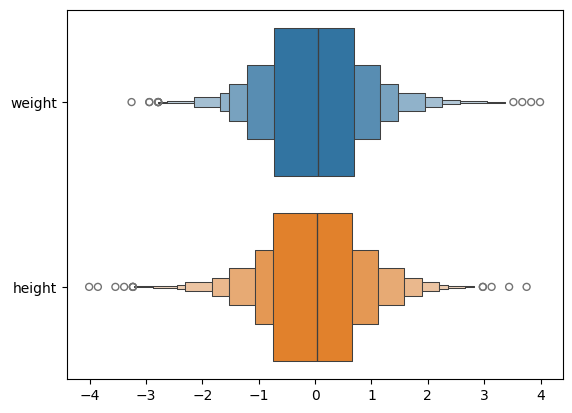

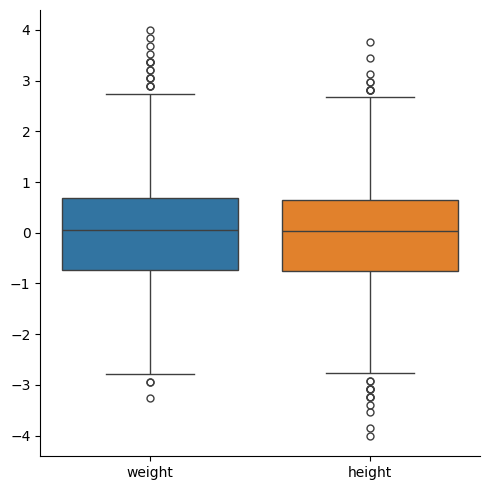

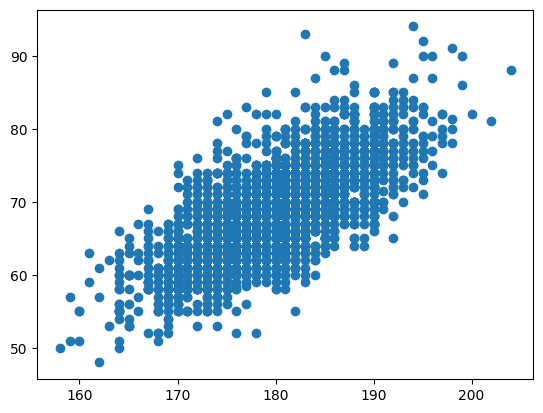

In [6]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [7]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

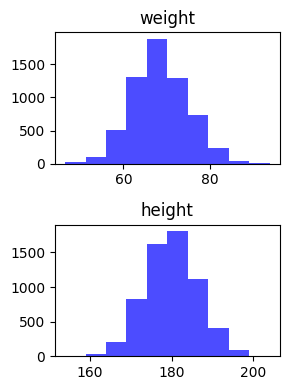

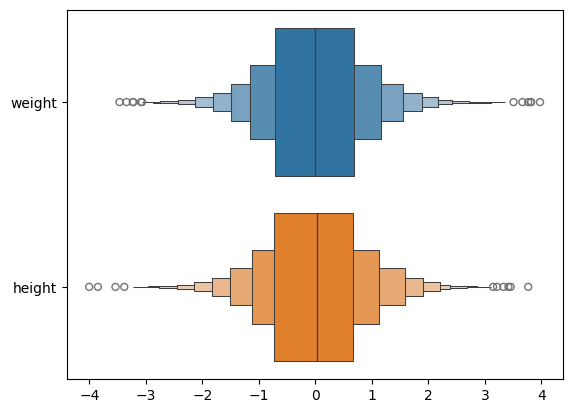

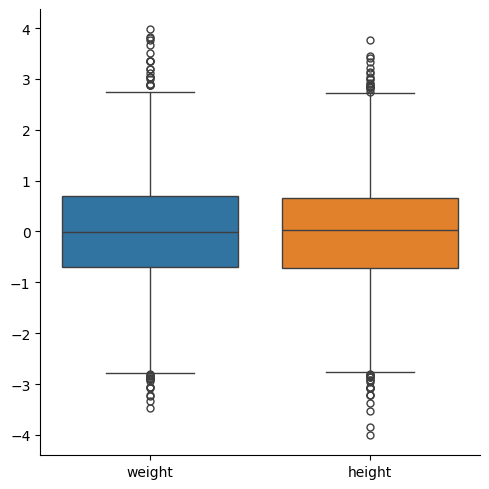

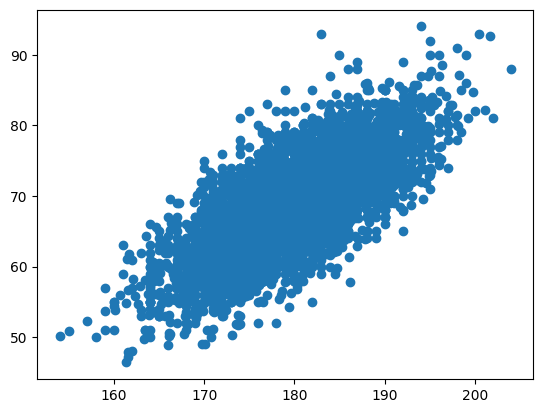

In [8]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti

### Fill data of birty_year column

In [ ]:
PreProcessing = DatasetRace.dropna(subset=["cyclist", "date", "cyclist_age"])

PreparedDatasetRace = pd.DataFrame({
    'name': PreProcessing["cyclist"],
    'date': list(map(lambda x, y: float(x.split("-")[0]) - y, PreProcessing["date"], PreProcessing["cyclist_age"]))
})

#Serve per vedere se per ogni ciclista ci sono più date di nascita calcolate, se si c'è un problema
GroupByCyclist = PreparedDatasetRace.groupby("name")
Counts = GroupByCyclist["date"].nunique()

for name in Counts:
    if(Counts[name] != 1): print(f"Risulta che l' atleta {name} non abbia una sola data ma: [{', '.join(list(set(GroupByCyclist['date'])))}]")

Non si sono presentati problemi, per ogni atleta si è calcolata una sola data di nascita considerando tutte le sue corse, quindi i dati interessati (date e cyclist_age) non sono sbagliati. Ora si usano questi dati per metterli dentro le date di nascita del dataset cyclists.

In [22]:
for date, name in zip(GroupByCyclist["date"], Counts):
    
    DatasetCyclists[]

6082 6082


## View final dataset cleaned

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134               0           6134
height               6134               0           6134
nationality          6134               0           6134


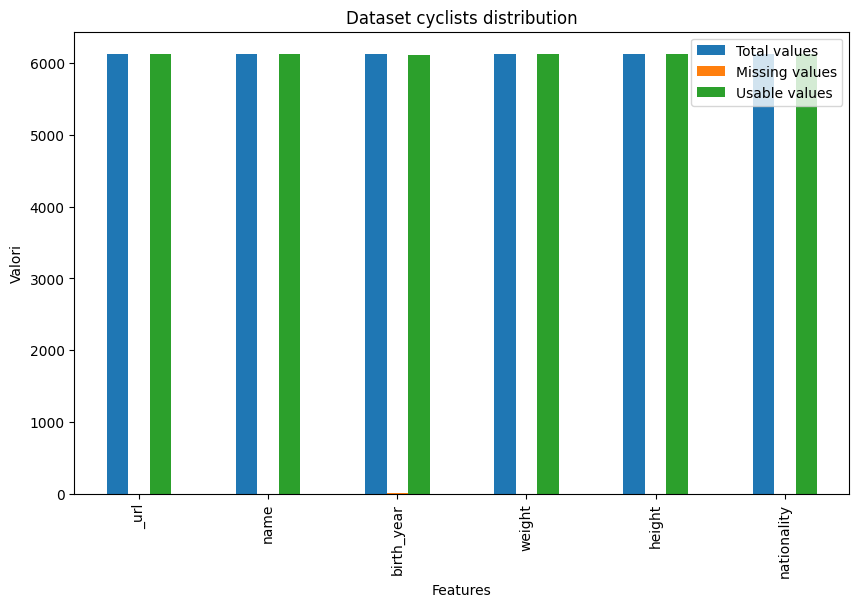

In [10]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

# **Cleaning race dataset**

### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [11]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

# View final dataset cleaned

                   Total values  Missing values  Usable values
Elements                                                      
_url                     589865               0         589865
name                     589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0         589865
cyclist                  589865               0         589865
cyclist_age              589865             113         589752
is_tarmac                589865               0         589865
is_cobbled               589865               0        

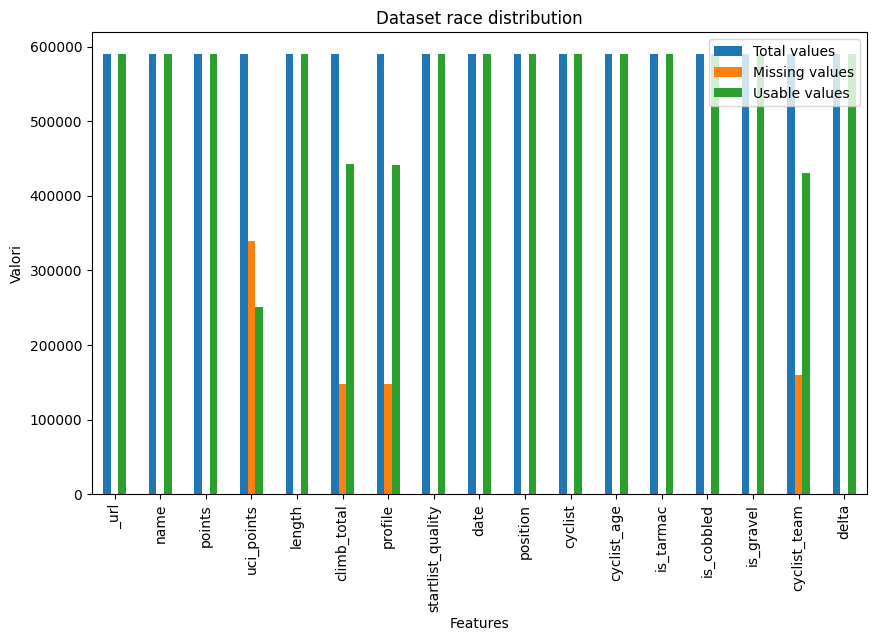

In [12]:
PlotMissingUsableData(DatasetRace, "race")

# **Feature engineering**

# Merge the datasets

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             589865               0         589865
birth_year               589865             113         589752
weight                   589865               0         589865
height                   589865               0         589865
nationality              589865               0         589865
name_race                589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0        

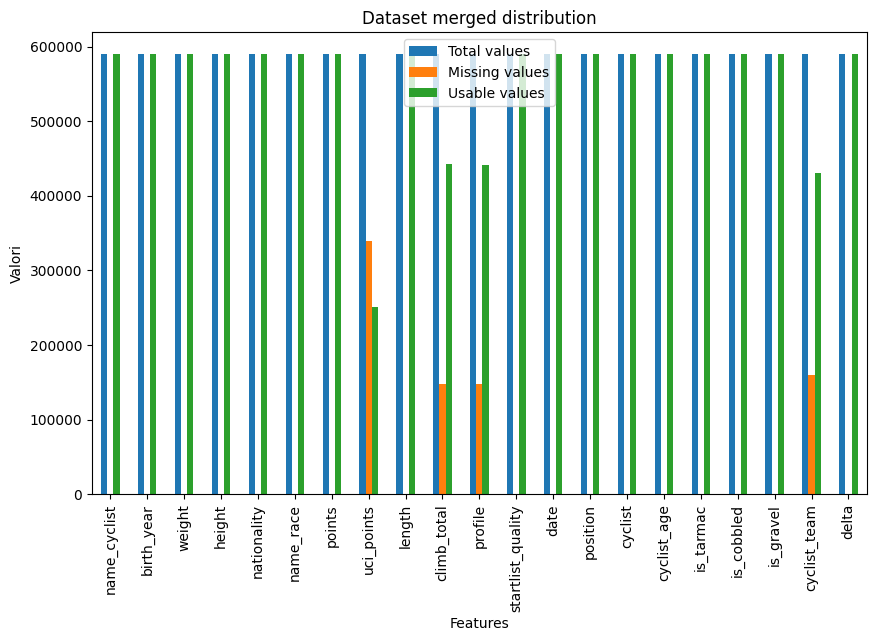

In [13]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")